In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score,f1_score,classification_report,precision_recall_curve,ConfusionMatrixDisplay
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold, cross_validate,TimeSeriesSplit,PredefinedSplit,KFold,train_test_split,GridSearchCV,RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders.wrapper import NestedCVWrapper
import gc 
import mglearn
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
full_train=pd.read_parquet("../data/processed/full_train.parquet")
full_priors=pd.read_parquet("../data/processed/full_priors.parquet")

In [3]:
orders=pd.read_csv("../data/raw/orders.csv")

we will use full_priors for feature engineering since it has the prior orders for each user and then merge full_train with these features for modeling

## User-level features

In [4]:
# 1) Basket size per order (how many products in each prior order)
user_fet=(full_priors.sort_values(['user_id', 'order_number']).groupby('user_id').agg(total_orders=('order_id', 'nunique'),
                                                                                  reorder_ratio=('reordered', 'mean'),
                                                                                  mean_days_between_orders=('days_since_prior_order', 'mean'),
                                                                                  last_order_recency=('days_since_prior_order', 'last'))
                                                                                  .reset_index())
avg_basket_size=(full_priors.groupby(['user_id', 'order_id']).size()
    .groupby('user_id').mean().rename('avg_basket_size').reset_index())

user_fet=user_fet.merge(avg_basket_size, on='user_id', how='left')
user_fet.head()


,user_id,total_orders,reorder_ratio,mean_days_between_orders,last_order_recency,avg_basket_size
0,1,10,0.694915,18.542374,30.0,5.900000
1,2,14,0.476923,14.902564,13.0,13.928571
2,3,12,0.625000,10.181818,15.0,7.333333
3,4,5,0.055556,11.944445,0.0,3.600000
4,5,4,0.378378,10.189189,19.0,9.250000


## Product-level features

In [5]:
product_fet=(full_priors.groupby('product_id').agg(product_reorder_rate=('reordered', 'mean'),
                                                   avg_pos_in_cart=('add_to_cart_order_winsor', 'mean'),
                                                   product_popularity=('product_id', 'size')).reset_index())
product_fet.head()

,product_id,product_reorder_rate,avg_pos_in_cart,product_popularity
0,1,0.613391,5.673866,1852
1,2,0.133333,9.455556,90
2,3,0.732852,6.176895,277
3,4,0.446809,9.246201,329
4,5,0.600000,6.466667,15


## User×Product interaction features

In [6]:
user_product_fet=(full_priors.sort_values(['user_id', 'product_id', 'order_number']).groupby(['user_id', 'product_id'])
    .agg(prior_purchase_count=('order_id', 'size'),
        days_since_last_purchase=('days_since_prior_order', 'last'),
        avg_reorder_prob=('reordered', 'mean')
    ).reset_index())

user_product_fet.head()


,user_id,product_id,prior_purchase_count,days_since_last_purchase,avg_reorder_prob
0,1,196,10,30.0,0.900000
1,1,10258,9,30.0,0.888889
2,1,10326,1,28.0,0.000000
3,1,12427,10,30.0,0.900000
4,1,13032,3,30.0,0.666667


## Temporal features

In [7]:
full_train['is_morning']=full_train['order_hour_of_day'].between(5, 11).astype(int)
full_train['is_afternoon']=full_train['order_hour_of_day'].between(12, 16).astype(int)
full_train['is_evening']=full_train['order_hour_of_day'].between(17, 20).astype(int)
full_train['is_night']=(~full_train['order_hour_of_day'].between(5, 20)).astype(int)

## Aggregations Over Windows
Average reorder rate over the user’s last 3 purchased products

In [8]:
max_order_num = full_priors.groupby('user_id')['order_number'].transform('max')
last_3_orders_data = full_priors[full_priors['order_number'] >= (max_order_num - 2)]

order_sizes = (
    last_3_orders_data.groupby(['user_id', 'order_id'])
    .size()
    .rename('basket_size')
    .reset_index()
)

avg_basket_size_last3 = (
    order_sizes.groupby('user_id')['basket_size']
    .mean()
    .rename('avg_basket_size_last3')
    .reset_index()
)

mean_days_last3 = (
    last_3_orders_data.drop_duplicates(['user_id', 'order_id'])
    .groupby('user_id')['days_since_prior_order']
    .mean()
    .rename('mean_days_last3')
    .reset_index()
)

user_last3_fet = mean_days_last3.merge(avg_basket_size_last3, on='user_id', how='left')


## Merging full_train with engineered features

In [9]:
full_train = (full_train
    .merge(user_fet, on='user_id', how='left')
    .merge(product_fet, on='product_id', how='left')
    .merge(user_product_fet, on=['user_id', 'product_id'], how='left')
    .merge(user_last3_fet,on='user_id',how='left')
)
full_train.head()

,user_id,product_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,is_first_order,product_name,...,last_order_recency,avg_basket_size,product_reorder_rate,avg_pos_in_cart,product_popularity,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,mean_days_last3,avg_basket_size_last3
0,202279,33120,1050357,train,9,1,14,30.0,0,Organic Egg Whites,...,30.0,11.25,0.708454,6.682062,19400,5,30.0,0.800000,28.0,13.333333
1,202279,28985,1050357,train,9,1,14,30.0,0,Michigan Organic Kale,...,30.0,11.25,0.694465,7.336195,67449,5,30.0,0.800000,28.0,13.333333
2,202279,9327,1050357,train,9,1,14,30.0,0,Garlic Powder,...,30.0,11.25,0.157962,9.474361,6299,1,8.0,0.000000,28.0,13.333333
3,202279,45918,1050357,train,9,1,14,30.0,0,Coconut Butter,...,30.0,11.25,0.272849,8.154570,744,5,24.0,0.800000,28.0,13.333333
4,202279,30035,1050357,train,9,1,14,30.0,0,Natural Sweetener,...,30.0,11.25,0.507909,8.189807,569,3,24.0,0.666667,28.0,13.333333


In [10]:
full_train.isna().sum().sum()

np.int64(0)

## Log Transforms
Log transformations were applied selectively to highly skewed count-based and continuous features.

In [11]:
full_train.skew(numeric_only=True).sort_values(ascending=False)

prior_purchase_count        6.006723
product_popularity          5.156164
is_night                    3.338144
reordered                   2.708012
is_evening                  1.503646
order_number                1.469936
total_orders                1.469936
avg_basket_size_last3       1.298662
avg_basket_size             1.259793
is_morning                  0.776363
days_since_last_purchase    0.753312
avg_reorder_prob            0.665294
last_order_recency          0.571140
mean_days_last3             0.512171
mean_days_between_orders    0.495662
days_since_prior_order      0.445228
is_afternoon                0.364664
order_dow                   0.116628
department_id               0.036345
order_id                    0.010949
user_id                     0.005768
is_first_order              0.000000
product_id                 -0.033735
order_hour_of_day          -0.099836
aisle_id                   -0.177863
reorder_ratio              -0.290826
product_reorder_rate       -0.685162
a

We used log1p instead of log to handle zero values

In [12]:
col_to_log=['prior_purchase_count','product_popularity','total_orders','order_number',
            'avg_basket_size','avg_basket_size_last3']
for col in col_to_log:
    full_train[col+'_log']=np.log1p(full_train[col])

Text(0.5, 1.0, 'Distribution of Total Orders\n(after log1p)')

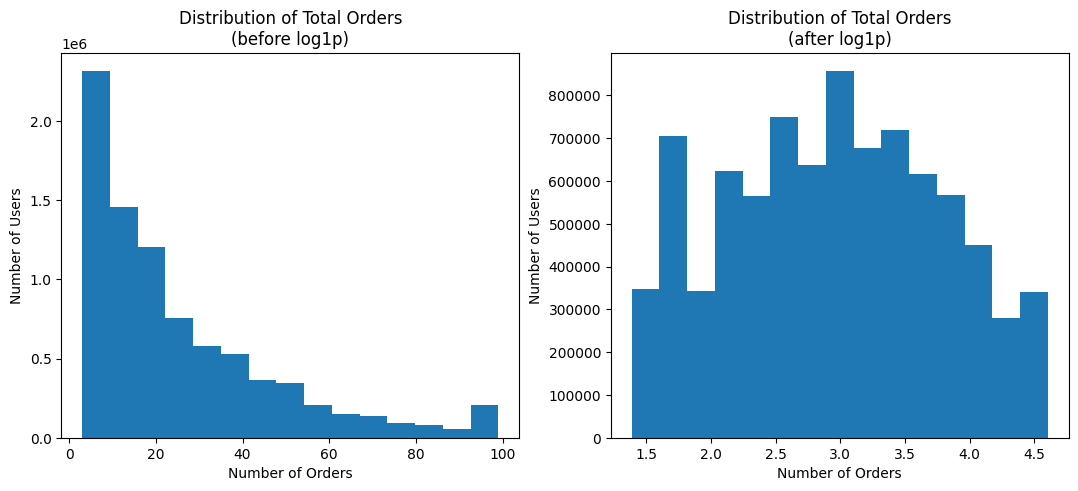

In [13]:
fig,axes=plt.subplots(1,2,figsize=(13,5))

axes[0].hist(full_train['total_orders'],bins=15)
axes[0].set_xlabel('Number of Orders')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Total Orders\n(before log1p)')

axes[1].hist(full_train['total_orders_log'],bins=15)
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Total Orders\n(after log1p)')

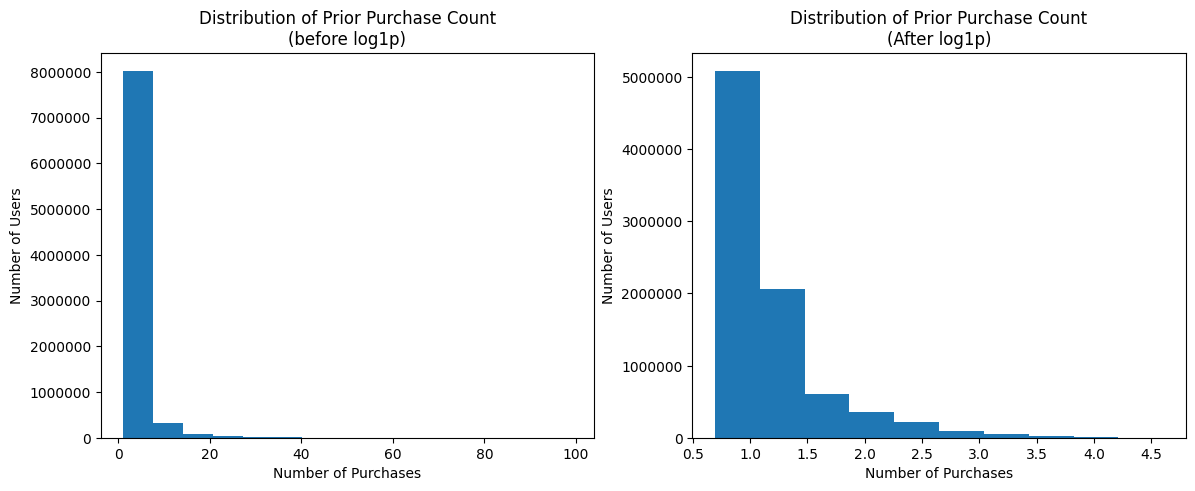

In [14]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

axes[0].hist(full_train['prior_purchase_count'],bins=15)
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Prior Purchase Count\n(before log1p)')
axes[0].ticklabel_format(style='plain')



axes[1].hist(full_train['prior_purchase_count_log'])
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Prior Purchase Count\n(After log1p)')
axes[1].ticklabel_format(style='plain')


In [15]:
#reg_df=orders.merge(user_fet,on='user_id',how='left').merge(avg_basket_size_last3,on='user_id',how='left').merge(mean_days_last3,on='user_id',how='left')
#reg_df=reg_df.drop('reorder_ratio',axis=1)
#reg_df.head()

In [16]:
#reg_df['days_since_prior_order']=reg_df['days_since_prior_order'].fillna(0)

In [17]:
#orders= orders.sort_values(['user_id', 'order_number'])
#
#orders['days_until_next_order'] = (
#    orders.groupby('user_id')['days_since_prior_order']
#    .shift(-1)
#)
#
#orders = orders.dropna(subset=['days_until_next_order'])


In [15]:
vif_cols = ['reorder_ratio','mean_days_between_orders','last_order_recency','mean_days_last3',
    'total_orders','product_reorder_rate','avg_pos_in_cart','product_popularity','avg_basket_size',
    'avg_basket_size_last3']


X_vif = full_train[vif_cols].copy()

X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(0)

# compute VIF
vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_df

,feature,VIF
0,avg_basket_size,20.577470
1,avg_pos_in_cart,16.821593
2,avg_basket_size_last3,16.653690
3,mean_days_between_orders,16.425358
4,mean_days_last3,16.243668
5,reorder_ratio,14.395802
6,product_reorder_rate,10.585153
7,last_order_recency,6.927535
8,total_orders,5.735301
9,product_popularity,1.441857


In [16]:
X_vif.drop(columns=['avg_basket_size_last3','mean_days_last3','avg_pos_in_cart','reorder_ratio'],axis=1,inplace=True)
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(0)

vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_df

,feature,VIF
0,product_reorder_rate,9.110821
1,mean_days_between_orders,8.742551
2,avg_basket_size,4.496362
3,last_order_recency,4.442392
4,total_orders,2.503508
5,product_popularity,1.368357


In [17]:
full_train.head()

,user_id,product_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,is_first_order,product_name,...,days_since_last_purchase,avg_reorder_prob,mean_days_last3,avg_basket_size_last3,prior_purchase_count_log,product_popularity_log,total_orders_log,order_number_log,avg_basket_size_log,avg_basket_size_last3_log
0,202279,33120,1050357,train,9,1,14,30.0,0,Organic Egg Whites,...,30.0,0.800000,28.0,13.333333,1.791759,9.873080,2.197225,2.302585,2.505526,2.662588
1,202279,28985,1050357,train,9,1,14,30.0,0,Michigan Organic Kale,...,30.0,0.800000,28.0,13.333333,1.791759,11.119142,2.197225,2.302585,2.505526,2.662588
2,202279,9327,1050357,train,9,1,14,30.0,0,Garlic Powder,...,8.0,0.000000,28.0,13.333333,0.693147,8.748305,2.197225,2.302585,2.505526,2.662588
3,202279,45918,1050357,train,9,1,14,30.0,0,Coconut Butter,...,24.0,0.800000,28.0,13.333333,1.791759,6.613384,2.197225,2.302585,2.505526,2.662588
4,202279,30035,1050357,train,9,1,14,30.0,0,Natural Sweetener,...,24.0,0.666667,28.0,13.333333,1.386294,6.345636,2.197225,2.302585,2.505526,2.662588


## Dropping Columns That We Won't Be Used Further (Redundant/leakage/meaningless).

In [18]:
col_to_drop=['avg_basket_size_last3','mean_days_last3','avg_pos_in_cart','reorder_ratio','eval_set','aisle',
             'prior_purchase_count','product_popularity','total_orders','avg_basket_size','order_number']
full_train=full_train.drop(columns=col_to_drop)
full_train.head()

,user_id,product_id,order_id,order_dow,order_hour_of_day,days_since_prior_order,is_first_order,product_name,aisle_id,department_id,...,last_order_recency,product_reorder_rate,days_since_last_purchase,avg_reorder_prob,prior_purchase_count_log,product_popularity_log,total_orders_log,order_number_log,avg_basket_size_log,avg_basket_size_last3_log
0,202279,33120,1050357,1,14,30.0,0,Organic Egg Whites,86,16,...,30.0,0.708454,30.0,0.800000,1.791759,9.873080,2.197225,2.302585,2.505526,2.662588
1,202279,28985,1050357,1,14,30.0,0,Michigan Organic Kale,83,4,...,30.0,0.694465,30.0,0.800000,1.791759,11.119142,2.197225,2.302585,2.505526,2.662588
2,202279,9327,1050357,1,14,30.0,0,Garlic Powder,104,13,...,30.0,0.157962,8.0,0.000000,0.693147,8.748305,2.197225,2.302585,2.505526,2.662588
3,202279,45918,1050357,1,14,30.0,0,Coconut Butter,19,13,...,30.0,0.272849,24.0,0.800000,1.791759,6.613384,2.197225,2.302585,2.505526,2.662588
4,202279,30035,1050357,1,14,30.0,0,Natural Sweetener,17,13,...,30.0,0.507909,24.0,0.666667,1.386294,6.345636,2.197225,2.302585,2.505526,2.662588


In [19]:
# Convert float64 to float32 to save 50% memory
for col in full_train.select_dtypes(include=['float64']).columns:
    full_train[col] = full_train[col].astype('float32')

# Convert int64 to int32
for col in full_train.select_dtypes(include=['int64']).columns:
    full_train[col] = full_train[col].astype('int32')

In [20]:
df=orders.loc[orders['eval_set'] == 'train', ['user_id','order_id']].sort_values('order_id')
split=int(len(df) * 0.9)
train_user_ids=df.iloc[:split]['user_id']
val_user_ids=df.iloc[split:]['user_id']

# REPLACE your df split with this
df_train=full_train[full_train['user_id'].isin(train_user_ids)].copy()
df_val=full_train[full_train['user_id'].isin(val_user_ids)].copy()
df_val=df_val.sort_values('order_id')

In [ ]:
#pos=df_train[df_train['reordered'] == 1]
#neg=df_train[df_train['reordered'] == 0].sample(n=len(pos)*4, random_state=42)   
#df_train=pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)
#df_train=df_train.sort_values('order_id')

In [21]:
X_train=df_train.drop(columns=['reordered','product_name','order_id'],axis=1)
y_train=df_train['reordered']

X_val=df_val.drop(columns=['reordered','product_name','order_id'],axis=1)
y_val=df_val['reordered']

## Encoding Comparision

In [22]:
df_train.nunique()

user_id                      118088
product_id                    49340
order_id                     118088
order_dow                         7
order_hour_of_day                24
days_since_prior_order           31
is_first_order                    1
product_name                  49340
aisle_id                        134
department_id                    21
department                       21
reordered                         2
is_morning                        2
is_afternoon                      2
is_evening                        2
is_night                          2
mean_days_between_orders      67349
last_order_recency               31
product_reorder_rate          16031
days_since_last_purchase         31
avg_reorder_prob                 99
prior_purchase_count_log         99
product_popularity_log         4161
total_orders_log                 97
order_number_log                 97
avg_basket_size_log           14256
avg_basket_size_last3_log       173
dtype: int64

In [ ]:
low_card=['order_dow','department','order_hour_of_day']
high_cat=['user_id', 'product_id'] 
num_col=list(X_train.drop(low_card+high_cat,axis=1))


In [141]:
preprocess_ohe=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                               ('scaler',StandardScaler(),num_col)],remainder='drop')

ohe_pipeline=Pipeline(steps=[('preprocess',preprocess_ohe),
                            ('model',LogisticRegression(class_weight='balanced'))])
ohe_pipeline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [142]:
ohe_pipeline.fit(X_train, y_train)
y_pred=ohe_pipeline.predict_proba(X_val)[:, 1]
roc_auc_ohe=roc_auc_score(y_val, y_pred)
avg_pr_ohe=average_precision_score(y_val, y_pred)

roc_auc_ohe, avg_pr_ohe

(0.7963537636796503, 0.3560422026540028)

In [143]:
# Use LeaveOneOutEncoder which is better for high-cardinality than basic TargetEncoder
# Adding 'sigma' (noise) is the key to stopping the 0.49 fake score
te_safe= ce.LeaveOneOutEncoder(cols=['product_id', 'user_id'], sigma=0.05)

preprocess_target = ColumnTransformer(transformers=[
    ('te', te_safe, high_cat),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), low_card),
    ('num', StandardScaler(), num_col)
], remainder='drop')

target_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_target),
    ('model', LogisticRegression(max_iter=300, class_weight='balanced'))
])

In [31]:
cv=TimeSeriesSplit(n_splits=5)
scores=cross_validate(
    target_pipeline,
    X_train, y_train,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "avg_pr": "average_precision"},
    n_jobs=-1
)
float(scores["test_roc_auc"].mean()),float(scores["test_avg_pr"].mean())

(0.7936883247194407, 0.5176339381388763)

In [144]:
target_pipeline.fit(X_train, y_train)
proba=target_pipeline.predict_proba(X_val)[:, 1]
roc_auc_target=roc_auc_score(y_val, proba)
avg_pr_target=average_precision_score(y_val, proba)
(roc_auc_target,avg_pr_target)

(0.7948074523680196, 0.342614327098743)

In [145]:
preprocess_frequency=ColumnTransformer(transformers=[('freq',ce.CountEncoder(cols=high_cat,normalize=True),high_cat),
                                                     ('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                                     ('num',StandardScaler(),num_col)],remainder='drop')
frequency_pipeline=Pipeline(steps=[('preprocess',preprocess_frequency),
                                  ('model',LogisticRegression(max_iter=5000,class_weight='balanced'))])
frequency_pipeline

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('freq', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [146]:
frequency_pipeline.fit(X_train,y_train)
proba=frequency_pipeline.predict_proba(X_val)[:,1]
roc_auc_freq=roc_auc_score(y_val,proba)
avg_pr_freq=average_precision_score(y_val,proba)

(roc_auc_freq,avg_pr_freq)

(0.7963537867280415, 0.35604213858863903)

In [147]:
results=pd.DataFrame({'roc_auc':[roc_auc_ohe,roc_auc_target,roc_auc_freq],
                      'avg_pr_score':[avg_pr_ohe,avg_pr_target,avg_pr_freq]},index=['OneHotEnc','TargetEnc','FrequencyEnc'])
results

,roc_auc,avg_pr_score
OneHotEnc,0.796354,0.356042
TargetEnc,0.794807,0.342614
FrequencyEnc,0.796354,0.356042


## Imbalanced data handling

In [24]:
df_train=df_train.drop(columns=['user_id','product_id','order_id'])
df_val=df_val.drop(columns=['user_id','product_id','order_id'])

X_train=df_train.drop(columns=['reordered','is_first_order'],axis=1)
y_train=df_train['reordered']

X_val=df_val.drop(columns=['reordered','is_first_order'],axis=1)
y_val=df_val['reordered']

In [200]:
print(f"reordered rate in train: {df_train['reordered'].mean():.2f}\nreordered rate in validation: {df_val['reordered'].mean():.2f}\n")
print(f"not reordered rate in train: {1-df_train['reordered'].mean():.2f}\nnot reordered rate in validation: {1-df_val['reordered'].mean():.2f}")


reordered rate in train: 0.10
reordered rate in validation: 0.10

not reordered rate in train: 0.90
not reordered rate in validation: 0.90


In [65]:
ct=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')
base_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression())])
base_pipline.fit(X_train,y_train)
y_pred=base_pipline.predict(X_val)
print(classification_report(y_val, y_pred,digits=2))


              precision    recall  f1-score   support

           0       0.91      0.99      0.95    762527
           1       0.64      0.09      0.16     83044

    accuracy                           0.91    845571
   macro avg       0.77      0.54      0.55    845571
weighted avg       0.88      0.91      0.87    845571



## dont forget delete

In [56]:
ct=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')

In [49]:
weight_pipline=Pipeline(steps=[('preprocess',ct),
                             ('model',LogisticRegression(class_weight='balanced'))])
weight_pipline.fit(X_train,y_train)
y_pred_weight=weight_pipline.predict(X_val)
print(classification_report(y_val,y_pred_weight))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    762527
           1       0.22      0.72      0.34     83044

    accuracy                           0.73    845571
   macro avg       0.59      0.72      0.58    845571
weighted avg       0.89      0.73      0.78    845571



In [62]:
ct_smote=ColumnTransformer(transformers=[('scaler',StandardScaler(),num_col)],remainder='drop')
smote_pipline=ImbPipeline(steps=[('preprocess',ct_smote),
                                 ('smote',SMOTE(sampling_strategy=0.30,random_state=42,k_neighbors=3)),
                                 ('model',LogisticRegression(n_jobs=-1))])


smote_pipline.fit(X_train,y_train)
y_pred_smote=smote_pipline.predict(X_val)
print(classification_report(y_val, y_pred_smote))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94    762527
           1       0.40      0.36      0.38     83044

    accuracy                           0.88    845571
   macro avg       0.67      0.65      0.66    845571
weighted avg       0.88      0.88      0.88    845571



## Classification Models

### Logistic Regression

In [ ]:
ct=ColumnTransformer(transformers=[('onehot',OneHotEncoder(handle_unknown='ignore'),low_card),
                                   ('scaler',StandardScaler(),num_col)],remainder='drop')
l2_log=Pipeline(steps=[('preprocess',ct),
                       ('model',LogisticRegression())])
l2_log.fit(X_train,y_train)
l2_y_pred=l2_log.predict(X_val)
proba=l2_log.predict_proba(X_val)[:,1]

0.9056531030510744

In [114]:
print("classification report for baseline logistic:\n",'\n',classification_report(y_val,l2_y_pred))

classification report for baseline logistic:
 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95    762527
           1       0.64      0.09      0.16     83044

    accuracy                           0.91    845571
   macro avg       0.77      0.54      0.55    845571
weighted avg       0.88      0.91      0.87    845571



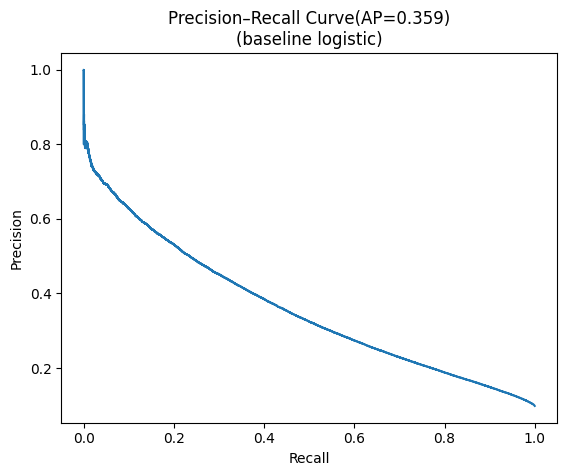

In [ ]:
prec,rec,_=precision_recall_curve(y_val,proba)
ap=average_precision_score(y_val,proba)
plt.plot(rec,prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve(AP={ap:.3f})\n(baseline logistic)")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

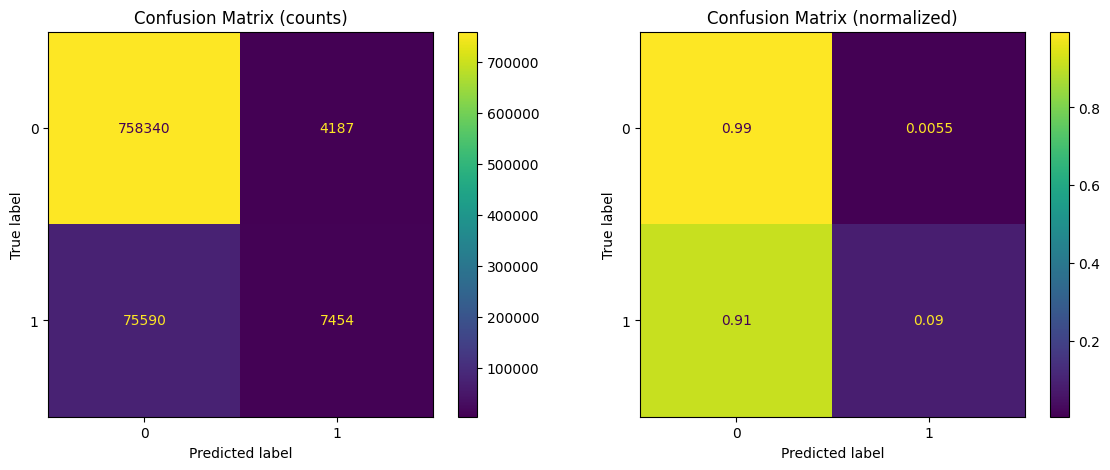

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val,l2_y_pred,normalize=None,ax=axes[0])
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val,l2_y_pred,normalize="true",ax=axes[1])
axes[1].set_title("Confusion Matrix (normalized)")

In [117]:
l1_log=Pipeline(steps=[('preprocess',ct),
                       ('model',LogisticRegression(penalty='l1',solver='saga'))])
l1_log.fit(X_train,y_train)
l1_y_pred=l1_log.predict(X_val)
proba=l1_log.predict_proba(X_val)[:,1]

In [119]:
print("classification report for L1 logistic:\n",'\n',classification_report(y_val,l1_y_pred))

classification report for L1 logistic:
 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95    762527
           1       0.64      0.09      0.16     83044

    accuracy                           0.91    845571
   macro avg       0.77      0.54      0.55    845571
weighted avg       0.88      0.91      0.87    845571



In [122]:
l2_weight_log=Pipeline(steps=[('preprocess',ct),
                       ('model',LogisticRegression(class_weight='balanced'))])
l2_weight_log.fit(X_train,y_train)
l2_weight_y_pred=l2_weight_log.predict(X_val)
proba=l2_weight_log.predict_proba(X_val)[:,1]

In [124]:
print("classification report for L2 Balanced logistic:\n",'\n',classification_report(y_val,l2_weight_y_pred))

classification report for L2 Balanced logistic:
 
               precision    recall  f1-score   support

           0       0.96      0.73      0.83    762527
           1       0.22      0.72      0.34     83044

    accuracy                           0.73    845571
   macro avg       0.59      0.72      0.58    845571
weighted avg       0.89      0.73      0.78    845571



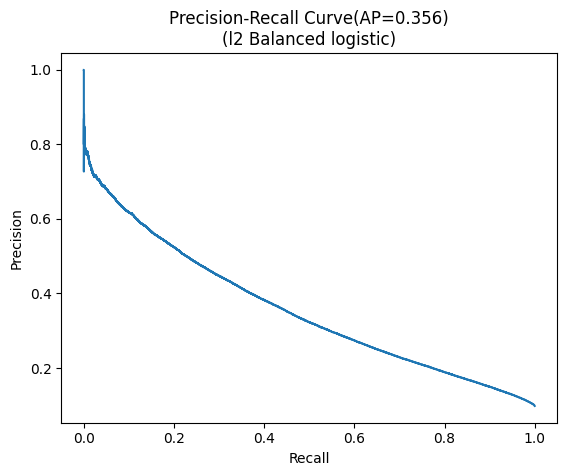

In [125]:
prec,rec,_=precision_recall_curve(y_val,proba)
ap=average_precision_score(y_val,proba)
plt.plot(rec,prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve(AP={ap:.3f})\n(l2 Balanced logistic)")
plt.show()

Text(0.5, 1.0, 'Confusion Matrix (normalized)')

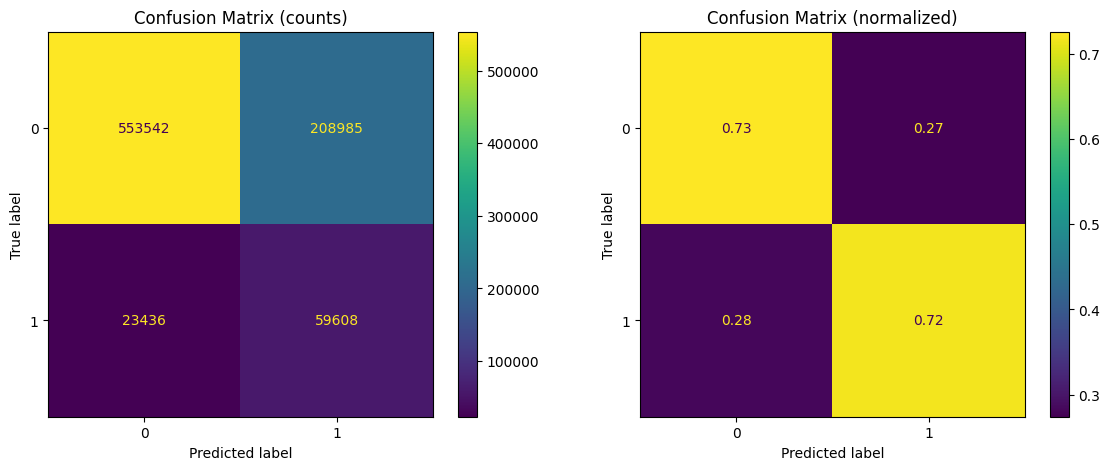

In [133]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
ConfusionMatrixDisplay.from_predictions(y_val, l2_weight_y_pred, normalize=None,ax=axes[0],values_format='d')
axes[0].set_title("Confusion Matrix (counts)")

ConfusionMatrixDisplay.from_predictions(y_val, l2_weight_y_pred, normalize="true",ax=axes[1],values_format='.2f')
axes[1].set_title("Confusion Matrix (normalized)")

In [ ]:
X2_train=df_train[["avg_reorder_prob","days_since_prior_order"]].values
y2_train=df_train["reordered"].values

X2_val=df_val[["avg_reorder_prob","days_since_prior_order"]].values
y2_val=df_val["reordered"].values
l2_bal_2d=make_pipeline(StandardScaler(),
                        LogisticRegression(class_weight={0:1,1:5}))
l2_bal_2d.fit(X2_train,y2_train)

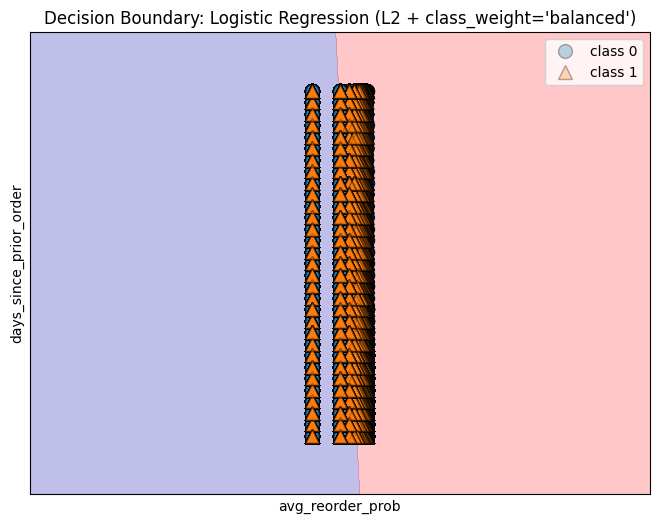

In [189]:
plt.figure(figsize=(8, 6))
mglearn.plots.plot_2d_separator(l2_bal_2d,X2_train,fill=True,alpha=0.25)
mglearn.discrete_scatter(X2_train[:,0],X2_train[:,1],y2_train,alpha=0.3)

plt.xlabel("avg_reorder_prob")
plt.ylabel("days_since_prior_order")
plt.title("Decision Boundary: Logistic Regression (L2 + class_weight='balanced')")
plt.legend(["class 0","class 1"],loc="best")
plt.show()

In [45]:
X_tune,_,y_tune,_=train_test_split(X_train, y_train,train_size=500_000,stratify=y_train,random_state=42)

In [57]:
grid_pip=Pipeline(steps=[('preprocess',ct),
                         ('logistic',LogisticRegression(n_jobs=-1,random_state=42,max_iter=3000))])
param_grid=[{
    'logistic__C':[0.01,0.1,1,10],
    'logistic__class_weight':[None,'balanced',{0:1,1:2},{0:1,1:5}],
    'logistic__penalty':['l1','l2'],
    'logistic__solver':['saga'],
}]
grid_search=HalvingGridSearchCV(grid_pip,param_grid,cv=3,scoring='f1')
grid_search.fit(X_tune,y_tune)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logistic__C': [0.01, 0.1, ...], 'logistic__class_weight': [None, 'balanced', ...], 'logistic__penalty': ['l1', 'l2'], 'logistic__solver': ['saga']}]"
,factor,3
,resource,'n_samples'
,max_resources,'auto'
,min_resources,'exhaust'
,aggressive_elimination,False
,cv,3
,scoring,'f1'
,refit,True
,error_score,nan


In [ ]:
best_model=grid_search.best_estimator_
best_model.fit(X_train,y_train)

,steps,"[('preprocess', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred = best_model.predict(X_val)
proba  = best_model.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91    762527
           1       0.31      0.53      0.39     83044

    accuracy                           0.84    845571
   macro avg       0.63      0.70      0.65    845571
weighted avg       0.88      0.84      0.85    845571



In [ ]:
best_lr=grid_search.best_estimator_.named_steps["logistic"]
best_lr.get_params()

{'C': 0.01,
 'class_weight': {0: 1, 1: 5},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 3000,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [68]:
clf2d=make_pipeline(StandardScaler(),
                        LogisticRegression(C=best_lr.C,class_weight=best_lr.class_weight,
                                           penalty=best_lr.penalty,solver=best_lr.solver))
clf2d.fit(X2_train,y2_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01


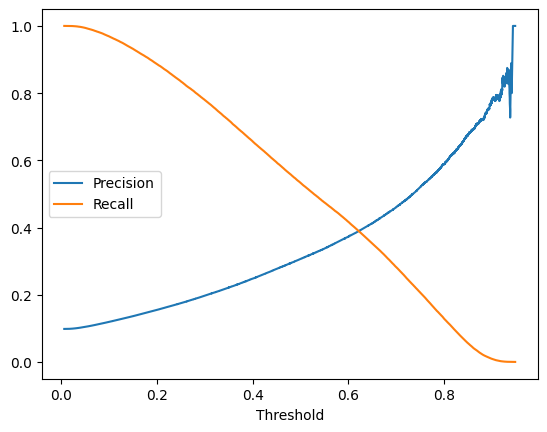

In [128]:
precisions, recalls, thresholds = precision_recall_curve(y_val, proba)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()



model: Precision = 37%, Recall = 42%

In [162]:
y_pred_new = (proba >= 0.6).astype(int)
print(classification_report(y_val, y_pred_new))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93    762527
           1       0.37      0.42      0.39     83044

    accuracy                           0.87    845571
   macro avg       0.65      0.67      0.66    845571
weighted avg       0.88      0.87      0.88    845571



Random guessing: Precision = 10%, Recall = 10%

So Model is 3.7x better on precision AND 4.2x better on recall than random guessing

In [163]:
print(f"pos rate: {y_pred_new.mean()}")

pos rate: 0.10986895245934404
